<a href="https://colab.research.google.com/github/hpan270/MSA/blob/master/TL_CIFAR10_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### transfer learning vgg16
- set trainable on block4_conv1 and block5_conv1
- use data augmentation
- after 10 epochs, acc=0.8687, val_acc=0.8005, score(test_acc)=0.5494
  
refer to https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [7]:
from keras.datasets import cifar10
from keras.utils import np_utils
import keras
num_classes=10
input_shape = (32, 32, 3)
# The data, split between train and test sets:
(X, Y), (x_test, y_test) = cifar10.load_data()

#Will be data scale when augmentation
# X = X / 255.0
# x_test = x_test / 255.0

# Convert class vectors to binary class matrices.
Y = np_utils.to_categorical(Y, 10)
y_test = np_utils.to_categorical(y_test, 10)

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, random_state=100)


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_validation.shape, 'validation shape')


x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
(10000, 32, 32, 3) validation shape


In [8]:
x_train[:1,:2,:2,:] # not scaled yet

array([[[[138, 140, 141],
         [ 75,  75,  70]],

        [[ 75,  79,  62],
         [ 58,  60,  42]]]], dtype=uint8)

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
  

In [10]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [0]:
from keras.preprocessing.image import ImageDataGenerator
#scaled here. Do data augmentation here for training set
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
#validation data set only do standardization
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
val_generator = val_datagen.flow(x_validation, y_validation, batch_size=32)

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras import layers
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

W0816 03:10:15.251084 139694647138176 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
history = model.fit_generator(train_generator, epochs=10,
                              validation_data=val_generator, 
                              steps_per_epoch=x_train.__len__()/10, 
                              validation_steps=x_validation.__len__()/10,
                              verbose=1)  


Epoch 1/10
4000/4000 [==============================] - 363s 91ms/step - loss: 1.1369 - acc: 0.6046 - val_loss: 0.7215 - val_acc: 0.7495
Epoch 2/10
4000/4000 [==============================] - 357s 89ms/step - loss: 0.8280 - acc: 0.7132 - val_loss: 0.6332 - val_acc: 0.7865
Epoch 3/10
4000/4000 [==============================] - 357s 89ms/step - loss: 0.7126 - acc: 0.7527 - val_loss: 0.6334 - val_acc: 0.7910
Epoch 4/10
4000/4000 [==============================] - 356s 89ms/step - loss: 0.6327 - acc: 0.7797 - val_loss: 0.6260 - val_acc: 0.7915
Epoch 5/10
4000/4000 [==============================] - 356s 89ms/step - loss: 0.5701 - acc: 0.8015 - val_loss: 0.5962 - val_acc: 0.8046
Epoch 6/10
4000/4000 [==============================] - 355s 89ms/step - loss: 0.5163 - acc: 0.8207 - val_loss: 0.6615 - val_acc: 0.7973
Epoch 7/10
4000/4000 [==============================] - 356s 89ms/step - loss: 0.4741 - acc: 0.8353 - val_loss: 0.6254 - val_acc: 0.8106
Epoch 8/10
4000/4000 [===================

In [19]:
import numpy as np
ypred=model.predict(x_test)
pred_labels=[x.argmax() for x in ypred[::1,:]]
test_labels=[x.argmax() for x in y_test[::1,:]]
print("Test Acc is {}".format((np.array(test_labels)==np.array(pred_labels)).mean()))

Test Acc is 0.5494


In [20]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 534us/step
Test loss: 7.106272584533691
Test accuracy: 0.5494


In [0]:
history.history.keys()
type(history.history)
history.history['acc']
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.head()
model.save('tl_vgg16.h5')
hist_df.to_csv('tl_vgg16.csv')

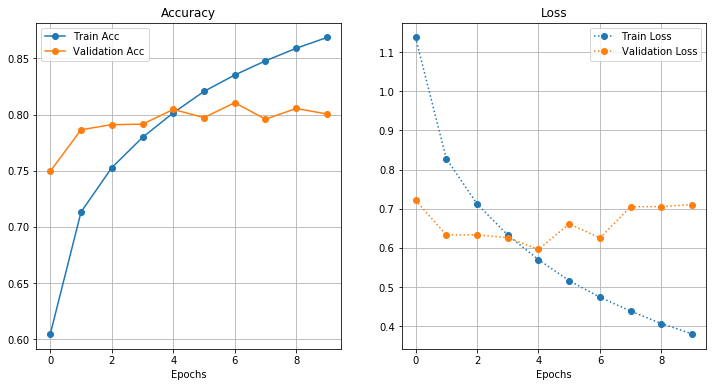

In [23]:
import matplotlib.pylab as plt
f=plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['acc'],'-o', label='Train Acc')
plt.plot(history.epoch, history.history['val_acc'],'-o',label='Validation Acc')  
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['loss'],':o', label='Train Loss')
plt.plot(history.epoch, history.history['val_loss'],':o',label='Validation Loss')  
plt.title("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')
f.savefig('tl_vgg16.png')

In [24]:
from google.colab import files

files.download('tl_vgg16.png')
files.download('tl_vgg16.csv')
files.download('tl_vgg16.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58552, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil